In [1]:
import pandas as pd
from datetime import date
import numpy as np
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [2]:
def amortize(principal, interest_rate, years, pmt, topup_principal, start_date, annual_payments):
    
    """
    Calculate the amortization schedule given the loan details.

    Parameters: 
               principal: Amount borrowed
               interest_rate: The annual interest rate for this loan
               years: Number of years for the loan
               pmt: Payment amount per period
               topup_principal: Additional payments to be made each period.
               start_date: Start date for the loan.
               annual_payments: Number of payments in a year.

    Return: 
        schedule: Amortization schedule as an Ortdered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = round(((interest_rate/annual_payments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        pmt = min(pmt, beg_balance + interest)
        principal = pmt - interest
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        topup_principal = min(topup_principal, beg_balance - principal)
        end_balance = beg_balance - (principal + topup_principal)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('Payment', pmt),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('Additional_Payment', topup_principal),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance
        
#Wrapper function to call amortize.
#This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.

def amortization_table(principal, interest_rate, years,
                       topup_principal=0, annual_payments=12, start_date=date.today()):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan
    Parameters:
               principal: Amount borrowed
               interest_rate: The annual interest rate for this loan
               years: Number of years for the loan
    
               annual_payments (optional): Number of payments in a year. DEfault 12.
               topup_principal (optional): Additional payments to be made each period. Default 0.
               start_date (optional): Start date. Default first of next month if none provided

    Returns: 
               schedule: Amortization schedule as a pandas dataframe
               summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Payment stays constant based on the original terms of the loan
    payment = -round(np.pmt(interest_rate/annual_payments, years*annual_payments, principal), 2)
    
    # Generate the schedule and order the resulting columns for convenience
    schedule = pd.DataFrame(amortize(principal, interest_rate, years, payment,
                                     topup_principal, start_date, annual_payments))
    schedule = schedule[["Period", "Month", "Begin Balance", "Payment", "Interest", 
                         "Principal", "Additional_Payment", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([payoff_date, schedule["Period"].count(), interest_rate,
                       years, principal, payment, topup_principal,
                       schedule["Interest"].sum()],
                       index=["Payoff Date", "Num Payments", "Interest Rate", "Years", "Principal",
                             "Payment", "Additional Payment", "Total Interest"])
    
    return schedule, stats

In [4]:
df, stats = amortization_table(760000, .031, 30, topup_principal=500, start_date=date(2020, 1,1))

In [5]:
stats

Payoff Date           2043-12-01 00:00:00
Num Payments                          288
Interest Rate                       0.031
Years                                  30
Principal                          760000
Payment                           3245.32
Additional Payment                    500
Total Interest                     318272
dtype: object

In [6]:
df.shape

(288, 8)

In [7]:
df.head()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2020-01-01,760000.00,3245.32,1963.33,1281.99,500.0,758218.01
1,2,2020-02-01,758218.01,3245.32,1958.73,1286.59,500.0,756431.42
2,3,2020-03-01,756431.42,3245.32,1954.11,1291.21,500.0,754640.21
3,4,2020-04-01,754640.21,3245.32,1949.49,1295.83,500.0,752844.38
4,5,2020-05-01,752844.38,3245.32,1944.85,1300.47,500.0,751043.91


## Benchmarking of different interest rate & Additional payment

In [10]:
schedule1, stats1 = amortization_table(700000, .03, 30, topup_principal=500, start_date=date(2020,1,1))
schedule2, stats2 = amortization_table(700000, .04, 30, topup_principal=1000, start_date=date(2020,1,1))
schedule3, stats3 = amortization_table(700000, .05, 15, topup_principal=250, start_date=date(2020,1,1))

In [11]:
pd.DataFrame([stats1, stats2, stats3])

,Payoff Date,Num Payments,Interest Rate,Years,Principal,Payment,Additional Payment,Total Interest
0,2043-08-01,284,0.03,30,700000,2951.23,500,277752.36
1,2039-04-01,232,0.04,30,700000,3341.91,1000,305812.13
2,2034-01-01,169,0.05,15,700000,5535.56,250,276002.19


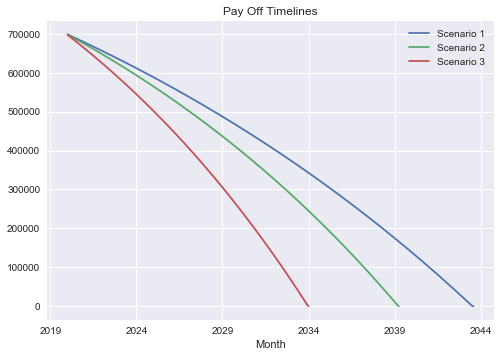

In [12]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Month', y='End Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Month', y='End Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Month', y='End Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");

In [13]:
def make_plot_data(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label"""
    y = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    y["Year"] = y["Month"].dt.year
    y.set_index('Year', inplace=True)
    y.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of ${}".format(stats['Years'], stats['Interest Rate']*100, stats['Additional Payment'])
    return y, label
    
y1, label1 = make_plot_data(schedule1, stats1)
y2, label2 = make_plot_data(schedule2, stats2)
y3, label3 = make_plot_data(schedule3, stats3)

y = pd.concat([y1, y2, y3], axis=1)

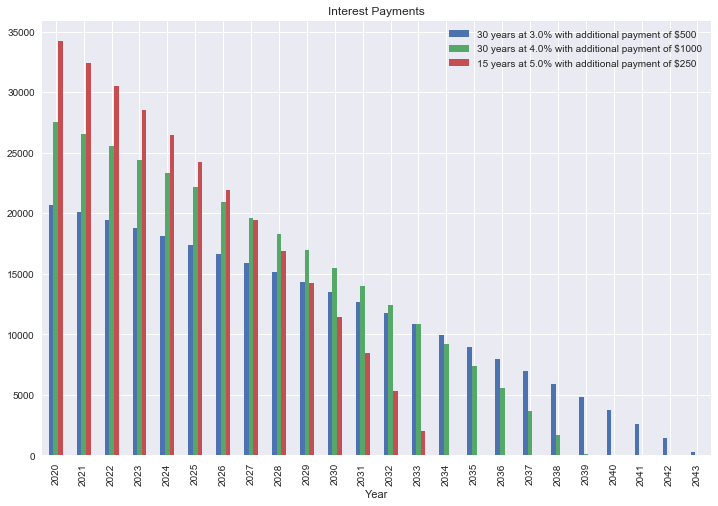

In [14]:
figsize(12,8)
fig, ax = plt.subplots(1, 1)
y.plot(kind="bar", ax=ax)

plt.legend([label1, label2, label3], loc=1, prop={'size':10})
plt.title("Interest Payments");

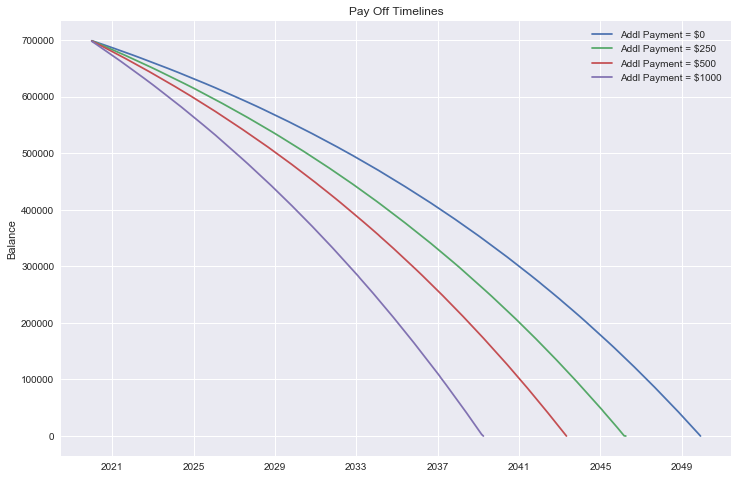

In [16]:
additional_payments = [0, 250, 500, 1000]
fig, ax = plt.subplots(1, 1)

for pmt in additional_payments:
    result, _ = amortization_table(700000, .04, 30, topup_principal=pmt, start_date=date(2020,1,1))
    ax.plot(result['Month'], result['End Balance'], label='Addl Payment = ${}'.format(str(pmt)))
plt.title("Pay Off Timelines")
plt.ylabel("Balance")
ax.legend();